In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test  = pd.read_csv('/kaggle/input/titanic/test.csv')
train_X, val_X, train_y, val_y = train_test_split(train, train.Survived,
                                                  test_size=0.2, random_state = 0)
#train.head()
#train.info()
#test.info()
null_percent = (train_X.isnull().sum()/train_X.isnull().count()).sort_values(ascending=False)
null_percent.head(10)



Cabin          0.771067
Age            0.198034
Embarked       0.002809
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
dtype: float64

Cabin, Age have too many missing values

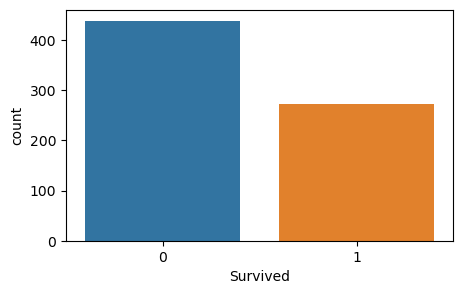

In [3]:
train_X['Survived'].describe()
plt.figure(figsize=(5,3))
sns.countplot(x='Survived', data=train_X);

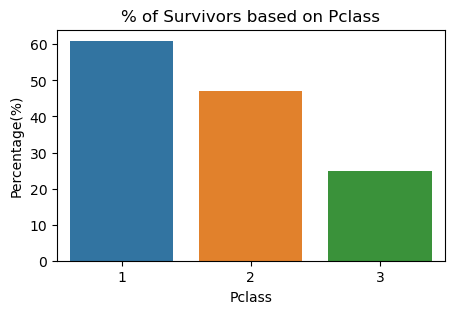

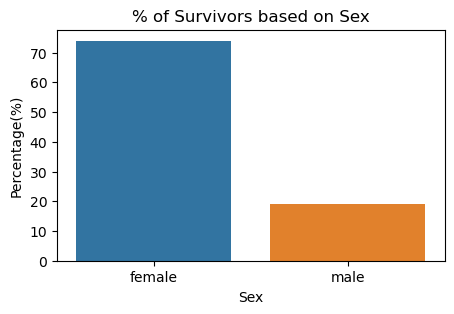

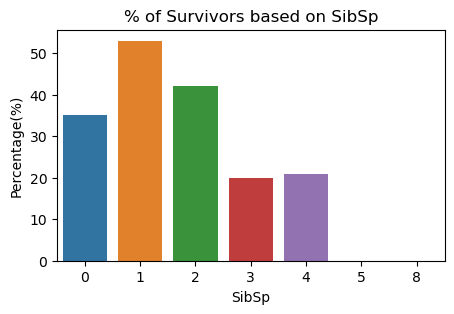

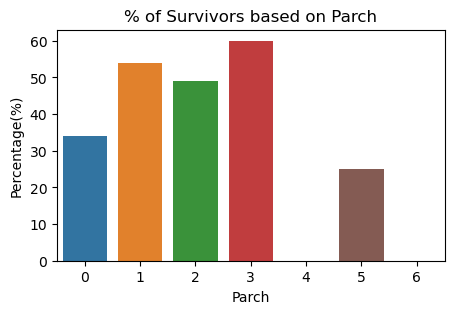

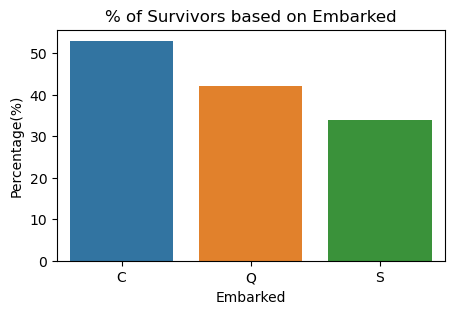

In [4]:
for i in ['Pclass','Sex','SibSp','Parch','Embarked']:
    plot_data = pd.pivot_table(data=train_X, index= i,values='Survived')*100
    plot_data = plot_data.round()

    plt.figure(figsize=(5,3))
    sns.barplot(data = plot_data,x=plot_data.index,y='Survived')

    plt.xlabel(i)
    plt.ylabel('Percentage(%)')
    plt.title('% of Survivors based on {}'.format(i))
    plt.show()

Categorical

In [5]:
train_X = train_X.replace( {"Sex" : {"female" : 0, "male" : 1} })
val_X = val_X.replace( {"Sex" : {"female" : 0, "male" : 1} })
test = test.replace( {"Sex" : {"female" : 0, "male" : 1} })

In [6]:
X_cols = [ 'Pclass', 'Sex', 'SibSp', 'Parch']

train_X_final = train_X[X_cols]
val_X_final = val_X[X_cols]
test_X = test[X_cols]


#Support Vector Machine
svm_param_grid  = {'C':[0.1, 1, 10], 
                   'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}

svm = SVC()
svm_cv = GridSearchCV(svm, svm_param_grid, cv=5)
svm_cv.fit(train_X_final, train_y)
svm_cv.best_params_
predicted_svm = svm_cv.predict(test_X)
#print(predicted_svm)
predicted_svm_val = svm_cv.predict(val_X_final)
print(accuracy_score(val_y,predicted_svm_val))

#K — Nearest Neighbor 
knn_param_grid  = {'n_neighbors':np.arange(1,10)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_param_grid, cv=5)
knn_cv.fit(train_X_final, train_y)
knn_cv.best_params_
predicted_knn = knn_cv.predict(test_X)
#print(predicted_knn)
predicted_knn_val = knn_cv.predict(val_X_final)
print(accuracy_score(val_y,predicted_knn_val))

#Logistic Regression
lor = LogisticRegression(random_state=0)
lor.fit(train_X_final, train_y)
predicted_lor = lor.predict(test_X)
#print(predicted_lor)
predicted_lor_val = lor.predict(val_X_final)
print(accuracy_score(val_y,predicted_lor_val))


#random forest classifier
rfc_param_grid  = {'random_state':[0], 
                   'n_estimators': np.arange(50, 300, 50)}

rfc = RandomForestClassifier()
rfc_cv = GridSearchCV(rfc, rfc_param_grid, cv=5)
rfc_cv.fit(train_X_final, train_y)
rfc_cv.best_params_
predicted_rfc = rfc_cv.predict(test_X)
#print(predicted_rfc)
predicted_rfc_val = rfc_cv.predict(val_X_final)
print(accuracy_score(val_y,predicted_rfc_val))


#DecisionTreeClassifier
dtc_param_grid  = {'max_features':np.arange(3, 10)}

dtc = DecisionTreeClassifier()
dtc_cv = GridSearchCV(dtc, dtc_param_grid, cv=5)
dtc_cv.fit(train_X_final, train_y)
dtc_cv.best_params_
predicted_dtc = dtc_cv.predict(test_X)
#print(predicted_dtc)
predicted_dtc_val = dtc_cv.predict(val_X_final)
print(accuracy_score(val_y,predicted_dtc_val))

predicted = predicted_svm + predicted_knn + predicted_lor + predicted_rfc + predicted_dtc
for i in range(len(predicted)):
    if predicted[i]>=3:
        predicted[i] = 1
    else:
        predicted[i] = 0
        
predicted_val = predicted_svm_val + predicted_knn_val + predicted_lor_val + predicted_rfc_val + predicted_dtc_val
for i in range(len(predicted_val)):
    if predicted_val[i]>=3:
        predicted_val[i] = 1
    else:
        predicted_val[i] = 0
        
print(accuracy_score(val_y,predicted_val))

0.8100558659217877
0.7877094972067039
0.7988826815642458
0.7988826815642458
0.7932960893854749
0.7988826815642458


In [7]:
my_submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predicted})
my_submission.to_csv('submission.csv', index=False)